# How much are top merchants spending per order? Are we retaining these top buyers?

To accomplish in this notebook- 
- Define "Top buyer" - They come every month? They have spent the most money? They spend a certain amount every month?
- Recommend definition of "top buyers" 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
baskets = pd.read_csv('new_baskets_full.csv')
baskets['datetime'] = baskets['placed_at'].apply(lambda x: datetime.fromisoformat(x))

#pandas.Series.dt is an interface on a pandas series that gives you convenient access to operations on data stored as a pandas datetime. 
baskets['date'] = baskets['datetime'].dt.date
baskets['year'] = baskets['datetime'].dt.year
baskets['month'] = baskets['datetime'].dt.month
baskets['day'] = baskets['datetime'].dt.day
baskets['hour'] = baskets['datetime'].dt.hour
baskets['weekday'] = baskets['datetime'].dt.weekday

#### Start by finding top buyers in terms of total amount spent.

In [2]:
baskets['spent'] = baskets['price'] * baskets['qty']

In [3]:
baskets.describe()

,id,order_id,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,year,month,day,hour,weekday,spent
count,336472.000000,336472.000000,336472.000000,336472.000000,336461.000000,336461.000000,3.364720e+05,3.364720e+05,336472.000000,336472.000000,336472.000000,336472.000000,336472.000000,3.364720e+05
mean,168236.500000,29079.405656,798.592706,525.308685,10.319098,45.395065,3.789684e+01,1.378956e+05,2021.539941,6.659588,15.970758,12.702486,2.620928,5.346555e+05
std,97131.244225,18909.738357,550.271799,304.262943,7.906257,27.767388,1.035873e+04,1.744689e+05,0.498403,3.932984,8.796420,4.228485,1.831302,2.859301e+06
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,4.375000e-02,2021.000000,1.000000,1.000000,0.000000,0.000000,5.000000e+00
25%,84118.750000,11485.000000,352.000000,322.000000,4.000000,27.000000,1.000000e+00,4.600000e+04,2021.000000,3.000000,8.000000,10.000000,1.000000,1.165000e+05
50%,168236.500000,28436.000000,664.000000,438.000000,8.000000,43.000000,2.000000e+00,1.070000e+05,2022.000000,7.000000,16.000000,12.000000,3.000000,2.080000e+05
75%,252354.250000,46193.250000,1217.000000,589.000000,14.000000,69.000000,5.000000e+00,1.845000e+05,2022.000000,11.000000,24.000000,15.000000,4.000000,4.350000e+05
max,336472.000000,62048.000000,2138.000000,1617.000000,33.000000,96.000000,4.800000e+06,5.875000e+07,2022.000000,12.000000,31.000000,23.000000,6.000000,3.831222e+08


Remove first 5 months of data from dataframe.

In [4]:
baskets.date.min()

datetime.date(2021, 4, 9)

In [5]:
baskets = baskets[baskets['date'] > pd.to_datetime('2021-7-31').date()]

In [6]:
baskets.date.min()

datetime.date(2021, 8, 1)

Find total amount spent by each merchant and sort highest to lowest.

In [7]:
baskets.groupby('merchant_id').spent.sum().sort_values(ascending = False)

merchant_id
664     3.947079e+09
441     1.729729e+09
366     1.724671e+09
122     1.491349e+09
430     1.441119e+09
            ...     
1158    3.575000e+05
1931    3.450000e+05
2018    3.290000e+05
411     3.190000e+05
1157    2.459000e+05
Name: spent, Length: 2128, dtype: float64

Notice that the top 5 most spending merchants are 664,441,366,122,430. Lets plot their spending over time to see if they are consistent spenders.

In [8]:
baskets['month_order'] = baskets['year']*12 + baskets['month']

Created month_order to reindex data to start at end of july

Created options to parse through top 5 spenders

In [9]:
options = [664,441,366,122,430]

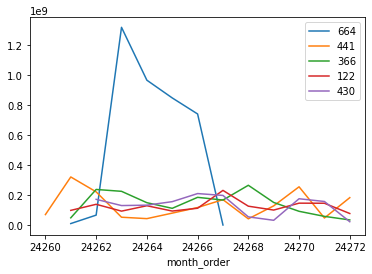

In [10]:
for i in range(5):
    baskets[baskets['merchant_id']==options[i]].groupby('month_order')['spent'].sum().plot().legend([664,441,366,122,430],fancybox = True)


Merchant 664 has a very unique buying pattern- looks like their last purchase was in March of 2022. They are defnitely an outlier, and seem to no longer be a customer. Remove 664 as top contender.

In [11]:
baskets[baskets['merchant_id'] == 664].date.max()

datetime.date(2022, 3, 25)

In [12]:
baskets = baskets.drop(baskets[baskets['merchant_id']== 664].index)

Now re-run data without 664.

In [13]:
baskets.groupby('merchant_id').spent.sum().sort_values(ascending = False)

merchant_id
441     1.729729e+09
366     1.724671e+09
122     1.491349e+09
430     1.441119e+09
305     1.368091e+09
            ...     
1158    3.575000e+05
1931    3.450000e+05
2018    3.290000e+05
411     3.190000e+05
1157    2.459000e+05
Name: spent, Length: 2127, dtype: float64

In [14]:
options = [441,366,122,430,305]

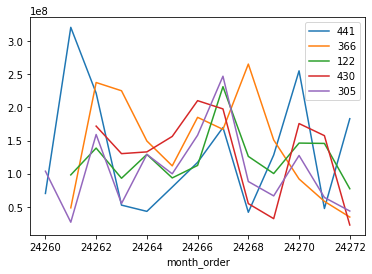

In [15]:
for i in range(5):
    baskets[baskets['merchant_id']==options[i]].groupby('month_order')['spent'].sum().plot().legend([441,366,122,430,305],fancybox = True)


This looks a lot better. Notice how all of the merchant's lines seem to fall between December and February? Why is this? It then also dips dramatically during Ramadon, which makes more sense *look into this later.

## Let's compare spending in the last 6 months. Will the same buyers be in the list?

In [16]:
sixbaskets = baskets[baskets['month_order'] > 24265]

In [17]:
sixbaskets.head()

,id,order_id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,datetime,date,year,month,day,hour,weekday,spent,month_order
191588,191782,33178,2022-02-01 04:59:15.772,1425,378,8.0,43.0,1,100500.0,2022-02-01 04:59:15.772,2022-02-01,2022,2,1,4,1,100500.0,24266
191589,191783,33178,2022-02-01 04:59:15.772,1425,380,8.0,43.0,1,100500.0,2022-02-01 04:59:15.772,2022-02-01,2022,2,1,4,1,100500.0,24266
191590,191784,33178,2022-02-01 04:59:15.772,1425,383,8.0,43.0,1,100500.0,2022-02-01 04:59:15.772,2022-02-01,2022,2,1,4,1,100500.0,24266
191591,191749,33923,2022-02-01 06:53:29.594,1702,511,3.0,91.0,1,104000.0,2022-02-01 06:53:29.594,2022-02-01,2022,2,1,6,1,104000.0,24266
191592,191750,33923,2022-02-01 06:53:29.594,1702,522,3.0,94.0,10,176000.0,2022-02-01 06:53:29.594,2022-02-01,2022,2,1,6,1,1760000.0,24266


In [18]:
sixbaskets.groupby('merchant_id').spent.sum().sort_values(ascending = False)

merchant_id
497     959077900.0
366     952641100.0
441     941911050.0
122     938894750.0
2084    932772739.0
           ...     
484        137500.0
195        123000.0
643         99500.0
706         62000.0
1435        53500.0
Name: spent, Length: 1728, dtype: float64

Top spenders are merchant_id's 497,366,441,122,2048.

441,366,122,430,305 were the top spenders over the year, it seems that 497 and 2048 have spent a lot more in the second half, while 430 and 305 have not sustained their high spending as much in the second half. 

In [19]:
options = [497,366,441,122,2048]

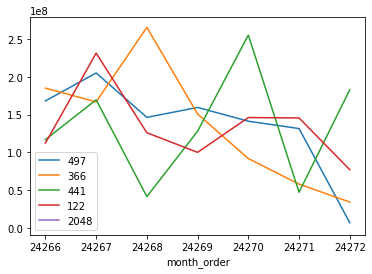

In [20]:
for i in range(5):
    sixbaskets[sixbaskets['merchant_id']==options[i]].groupby('month_order')['spent'].sum().plot().legend([497,366,441,122,2048],fancybox = True)


Looks like all sales are declining in July of 2022 besides 441. Why is this? 441 seems to have a regular pattern of large orders every two months. They are consistent, which is valuable. There are not any outliers, so let's look at the sales from 430 and 305 in the second half to see if they are still top buyers. 

Looking at this new graph, I see no outliers, everyone is still purchasing now semi-consitently.
For the monetary score, I am going to use the data from the whole year. This is because changes in the last 6 months may be more relevant to the frequency score. 
Top 5 are: 
1. 441 (5)
2. 366 (4)
3. 122 (3)
4. 430 (2)
5. 305 (1)

RFM- recency, frequency, monetary. 
Find matrix to rank buyers by all three. 
R+F+M = Score. 
Recency is not as relevant

## Next, I am going to work on frequency: The angle I will take to rank frequency is whoever has the highest number of orders.

for each merchant, total their orders per month.


In [21]:
baskets.groupby(['merchant_id']).order_id.nunique().sort_values(ascending = False)

merchant_id
414    497
366    315
470    284
29     279
308    246
      ... 
47       1
114      1
42       1
95       1
37       1
Name: order_id, Length: 2127, dtype: int64

<AxesSubplot:xlabel='merchant_id'>

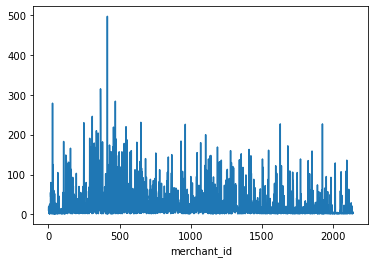

In [22]:
baskets.groupby(['merchant_id']).order_id.nunique().plot()

Plot to show how many purchases each merchant has made over the year. Notice how much 414 stands out. They are far and away the most frequent purchaser. 

Top orderers are 
1. 414 (5)
2. 366 (4)
3. 470 (3)
4. 29  (2) 
5. 308 (1)

Let's look at their order habits over time.

In [23]:
options = [414,366,470,29,308]

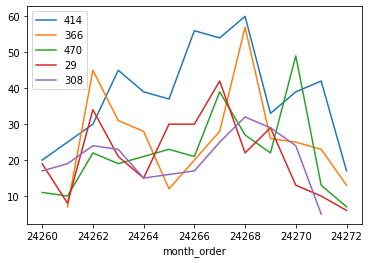

In [24]:
for i in range(5):
    baskets[baskets['merchant_id']==options[i]].groupby('month_order')['order_id'].nunique().plot().legend([414,366,470,29,308],fancybox = True)


It looks like all merchants have consistently made orders over the year, following a generally consistent pattern. I notice that the orders drop a bit at the end- is this because of a holiday? or covid rising again over the summer?

Lets plot what their spending habits are.

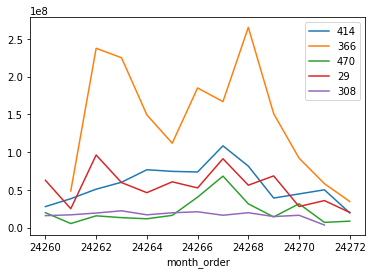

In [25]:
for i in range(5):
    baskets[baskets['merchant_id']==options[i]].groupby('month_order')['spent'].sum().plot().legend([414,366,470,29,308],fancybox = True)


366 is spending quit a bit over the year. This makes sense because they were also on the list for top spenders.

I wonder how many items they are buying? Are their orders large or small?

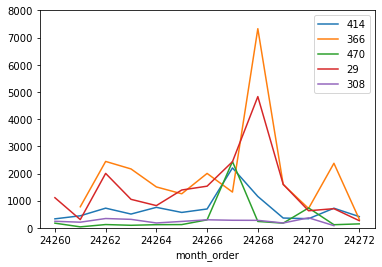

In [26]:
for i in range(5):
    baskets[baskets['merchant_id']==options[i]].groupby('month_order')['qty'].sum().plot(ylim = (0, 8000)).legend([414,366,470,29,308],fancybox = True)


All of the merchants spiked in their items purchased in March through april. Their spending also spiked during this time. I predicted that this would not happen because of the Ramadon holiday. Maybe they are buying more because people want to not go far from home to shop so corner stores have large stock?

### I've been noticing that a lot of the significant statistics are with merchants with low merchant id's compared to the median. Could this be becuase they assign merchant id's in the order in which they start buying? This would make sense because higher merchant id's wouldnt have the same amount of time to biuld up profiles that would spend a lot of money. In another year, some of the bigger merchants may be in the 1-2 thousands. Let's test just the last month for frequency and overall spending to see if there are higher merchant id's in the running, which would support my hypothesis. 

In [27]:
onemonth = baskets[baskets['month_order'] > 24270]

In [28]:
onemonth.groupby('merchant_id').spent.sum().sort_values(ascending = False)

merchant_id
441     230345000.0
122     222857750.0
2095    185714500.0
430     179879750.0
1770    148284950.0
           ...     
1550       223000.0
1743       160000.0
485        128000.0
534        115000.0
1765       107000.0
Name: spent, Length: 389, dtype: float64

In [29]:
onemonth.groupby(['merchant_id']).order_id.nunique().sort_values(ascending = False)

merchant_id
2095    75
2088    63
1924    59
414     59
249     53
        ..
1125     1
1209     1
1265     1
1291     1
630      1
Name: order_id, Length: 389, dtype: int64

As I predicted, there has been a sharp rise of higher merchant id order numbers in the last month. Many merchants with ids in the thousands have broken into the top 5 both for spending and for frequency. This doesn't affect our overall findings, but note this caveat in the poster. Our top spenders now will probably not continue forever with the new merchants spending a lot. 

Now, returning to the RFM ranking, my results are:
1. 366 (8)
2. 414 (5)
3. 441 (5)
4. 470 (3)
5. 122 (3)

I gave prefferentail treatment to top spenders rather than frequent purchasers, since to a for-profit business, money spent is the ultimate measure.

### According to my findings, I recommend that the company does not place too much stock in past top buyers. Evaluating on a month-by-month basis may be more useful since new merchants are joining often. Let's try to refine a definition for a "top buyer"

I think a better way to estimate the value of a customer to the company would be some statistics for a specific merchant over thier time as a customer. I am going to make a merchant table to try to do this. 

In [30]:
merchants = baskets.groupby(['merchant_id']).agg({'spent': 'sum', 'order_id': 'nunique', 'date': 'nunique', 'sku_id':'nunique', 'top_cat_id':'nunique', 'sub_cat_id':'nunique'}).reset_index()

In [31]:
merchants.sample(10)

,merchant_id,spent,order_id,date,sku_id,top_cat_id,sub_cat_id
148,157,29297200.0,23,16,33,11,20
132,141,521530250.0,33,32,269,24,56
1434,1446,1276000.0,2,2,4,3,4
2021,2033,22021428.0,2,2,23,6,12
313,323,10478000.0,11,10,20,6,10
1000,1012,65939500.0,19,15,63,15,31
130,139,69187950.0,18,15,94,10,22
367,377,7623500.0,2,2,4,3,3
950,962,58821200.0,19,19,153,18,47
2034,2046,19885660.0,2,2,35,8,13


How can we use this to find the top merchants over time? I want to find their total spending and divide it over the time they've been a customer. lets make a new dataframe to better prepare for this.

In [32]:
dfmerch = baskets.groupby(['merchant_id']).agg({'spent': 'sum', 'month_order': 'min', 'order_id':'nunique'})

In [33]:
dfmerch.sample(10)

,spent,month_order,order_id
merchant_id,,,
353,153985750.0,24260,137
893,34767500.0,24262,23
261,17508500.0,24265,4
926,10182500.0,24262,9
478,85077465.0,24260,148
1698,5374250.0,24266,9
320,5480300.0,24260,11
550,55433750.0,24260,11
1171,30398500.0,24262,26


Now lets use this to make a row that shows the months that they've been a customer.

In [34]:
dfmerch['loyalty'] = 24273 - dfmerch['month_order']

In [35]:
dfmerch.sample(10)

,spent,month_order,order_id,loyalty
merchant_id,,,,
1684,7806000.0,24265,9,8
358,112566049.0,24261,108,12
1703,2377500.0,24265,7,8
1009,21323750.0,24262,18,11
310,107901800.0,24260,25,13
1348,105573342.0,24263,43,10
863,77739900.0,24262,68,11
28,38629000.0,24262,6,11
890,69107500.0,24262,5,11


Now we can use this data to rank merchants in terms of money spent over the months they've been a customer.

In [36]:
dfmerch['avgspent'] = dfmerch['spent'] / dfmerch['loyalty']

In [37]:
dfmerch.sample(10)

,spent,month_order,order_id,loyalty,avgspent
merchant_id,,,,,
1342,4876500.0,24265,2,8,6.095625e+05
1794,35461816.0,24266,5,7,5.065974e+06
528,179649500.0,24260,38,13,1.381919e+07
719,257089500.0,24261,63,12,2.142412e+07
1076,36045000.0,24262,16,11,3.276818e+06
1506,28014750.0,24264,21,9,3.112750e+06
1100,120839250.0,24262,123,11,1.098539e+07
1704,11800000.0,24265,9,8,1.475000e+06
1446,1276000.0,24263,2,10,1.276000e+05


In [38]:
dfmerch['avgspent'].sort_values(ascending = False)

merchant_id
2084    1.865545e+08
12      1.624243e+08
366     1.437226e+08
441     1.330561e+08
430     1.310108e+08
            ...     
446     3.676923e+04
46      3.636364e+04
1022    3.613636e+04
1158    3.250000e+04
1157    2.235455e+04
Name: avgspent, Length: 2127, dtype: float64

Now we can see that if we are not including how long a merchant has been a customer that we have a new top 5 spenders. 

They are:
1. 2084
2. 12
3. 366
4. 441
5. 430

Looking more into merchant_id 2084, they have only ever made 3 orders, all being in April of 2022. They have spent a lot, but are an outlier and have not made any orders recently, so I am removing that merchant.

In [59]:
baskets[baskets['merchant_id']==2084].head(10)

,id,order_id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,datetime,date,year,month,day,hour,weekday,spent,month_order
278976,279102,51311,2022-04-26 19:36:41.350,2084,1169,11.0,4.0,519,14000.0,2022-04-26 19:36:41.350,2022-04-26,2022,4,26,19,1,7266000.0,24268
278977,279103,51311,2022-04-26 19:36:41.350,2084,548,11.0,86.0,2,95000.0,2022-04-26 19:36:41.350,2022-04-26,2022,4,26,19,1,190000.0,24268
278978,279104,51311,2022-04-26 19:36:41.350,2084,547,4.0,4.0,7,60000.0,2022-04-26 19:36:41.350,2022-04-26,2022,4,26,19,1,420000.0,24268
278979,279105,51311,2022-04-26 19:36:41.350,2084,735,11.0,28.0,25,37500.0,2022-04-26 19:36:41.350,2022-04-26,2022,4,26,19,1,937500.0,24268
278980,279106,51311,2022-04-26 19:36:41.350,2084,1447,4.0,51.0,57,287000.0,2022-04-26 19:36:41.350,2022-04-26,2022,4,26,19,1,16359000.0,24268
278981,279107,51311,2022-04-26 19:36:41.350,2084,1298,4.0,51.0,2,284500.0,2022-04-26 19:36:41.350,2022-04-26,2022,4,26,19,1,569000.0,24268
278982,279108,51311,2022-04-26 19:36:41.350,2084,1201,4.0,51.0,4,284500.0,2022-04-26 19:36:41.350,2022-04-26,2022,4,26,19,1,1138000.0,24268
278983,279109,51311,2022-04-26 19:36:41.350,2084,542,14.0,32.0,1,131500.0,2022-04-26 19:36:41.350,2022-04-26,2022,4,26,19,1,131500.0,24268
278984,279110,51311,2022-04-26 19:36:41.350,2084,524,3.0,94.0,403,121000.0,2022-04-26 19:36:41.350,2022-04-26,2022,4,26,19,1,48763000.0,24268
278985,279111,51311,2022-04-26 19:36:41.350,2084,523,3.0,94.0,3,212500.0,2022-04-26 19:36:41.350,2022-04-26,2022,4,26,19,1,637500.0,24268


In [61]:
baskets = baskets.drop(baskets[baskets['merchant_id'] == 2084].index)

In [67]:
dfmerch = dfmerch.drop(2084)

Re-run top 5.

In [68]:
dfmerch['avgspent'].sort_values(ascending = False)

merchant_id
12      1.624243e+08
366     1.437226e+08
441     1.330561e+08
430     1.310108e+08
122     1.242791e+08
            ...     
446     3.676923e+04
46      3.636364e+04
1022    3.613636e+04
1158    3.250000e+04
1157    2.235455e+04
Name: avgspent, Length: 2126, dtype: float64

In [74]:
options = [12, 366, 441, 430, 122]

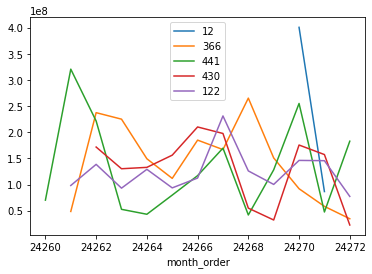

In [75]:
for i in range(5):
    baskets[baskets['merchant_id']==options[i]].groupby('month_order')['spent'].sum().plot().legend([12, 366, 441, 430, 122],fancybox = True)

Clearly, 12 has spent a lot since being a customer, but are they an outlier? When was their last order? Why is their spending at such a sharp decline?

In [76]:
baskets[baskets['merchant_id']==12].date.min()

datetime.date(2022, 6, 25)

In [77]:
baskets[baskets['merchant_id']==12].date.max()

datetime.date(2022, 7, 4)

All of their orders fall between a 9 day period. That is irregular and they need to be removed. 

In [81]:
baskets = baskets.drop(baskets[baskets['merchant_id']==12].index)

In [82]:
dfmerch = dfmerch.drop(12)

In [83]:
dfmerch['avgspent'].sort_values(ascending = False)

merchant_id
366     1.437226e+08
441     1.330561e+08
430     1.310108e+08
122     1.242791e+08
305     1.052377e+08
            ...     
446     3.676923e+04
46      3.636364e+04
1022    3.613636e+04
1158    3.250000e+04
1157    2.235455e+04
Name: avgspent, Length: 2125, dtype: float64

In [85]:
options = [366, 441, 430, 122, 305]

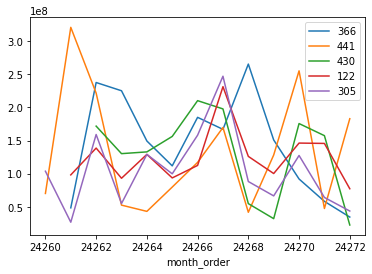

In [86]:
for i in range(5):
    baskets[baskets['merchant_id']==options[i]].groupby('month_order')['spent'].sum().plot().legend([366, 441, 430, 122, 305],fancybox = True)

Each merchant in this plot looks like they are not outliers. These top five are:
1. 366
2. 441
3. 430
4. 122
5. 305

These two models for finding the top 5 reconcile pretty well with each other. 3/5 of the top 5 match, and 366 is the top customer in both. I feel that the second model represents a more fair analysis because all of the customers seem to have been loyal for a long time, so we are not ignoring new customers. These top 5 are the biggest spenders over all time, but also over each month they've purchased from us on average. 

<AxesSubplot:xlabel='loyalty'>

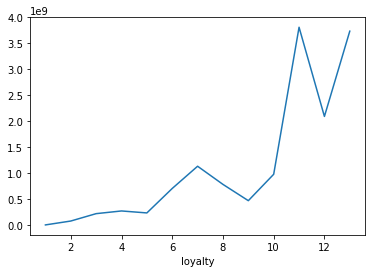

In [93]:
dfmerch.groupby(by ='loyalty')['avgspent'].sum().plot()

Wow- from how this graph looks, the customers that have been with us longer clearly spend more per month. This could be because there are more of them- let's try to filter this variable out.